# UFC Automated Scoring

The goal of this notebook is to:
* Read in stored, scraped UFC data and convert it into a dataset ready for ML models
* Train, test, and analyze ML models

Functional as of April 2021

## Read in stored data

In [1]:
import numpy as np
import pandas as pd

In [2]:
STORED_FIGHT_TABLE = pd.read_csv('data/April_22_2021_better_data/FIGHT_TABLE_NUM_EVENTS_All_DATA_MODE_Summary_22-04-2021_11:08:22.csv')

In [3]:
STORED_FIGHT_TABLE

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,...,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground,Winner,Method
0,0,0,150,62,52.0,29.0,169,70,4,1,...,22,13,138,59,5,3,7,0,0,U-DEC
1,0,0,105,88,47.0,45.0,109,99,0,0,...,25,17,103,84,2,4,0,0,0,U-DEC
2,0,0,21,27,44.0,49.0,32,91,0,8,...,1,1,14,18,5,3,2,6,1,U-DEC
3,0,1,66,55,58.0,46.0,84,72,3,0,...,7,17,39,50,7,4,20,1,0,S-DEC
4,0,0,90,80,46.0,47.0,90,82,0,4,...,4,20,88,77,2,3,0,0,0,S-DEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5888,2,0,24,16,68.0,33.0,49,31,0,1,...,12,0,17,7,4,4,3,5,0,KO/TKO Punch
5889,0,0,19,24,55.0,55.0,95,145,1,2,...,5,2,4,1,15,23,0,0,0,S-DEC
5890,0,0,14,13,35.0,19.0,30,15,3,0,...,3,0,11,12,0,1,3,0,0,U-DEC
5891,0,0,9,3,56.0,60.0,17,11,1,0,...,2,0,2,0,5,3,2,0,0,SUB Guillotine Choke


In [263]:
# Clean dataset: Only decisions with clear winners
STORED_FIGHT_TABLE = STORED_FIGHT_TABLE[STORED_FIGHT_TABLE["Method"].str.contains("DEC")]
STORED_FIGHT_TABLE = STORED_FIGHT_TABLE[(STORED_FIGHT_TABLE["Winner"] == 1) | (STORED_FIGHT_TABLE["Winner"] == 0)]
STORED_FIGHT_TABLE

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,...,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground,Winner,Method
0,0,0,150,62,52.0,29.0,169,70,4,1,...,22,13,138,59,5,3,7,0,0,U-DEC
1,0,0,105,88,47.0,45.0,109,99,0,0,...,25,17,103,84,2,4,0,0,0,U-DEC
2,0,0,21,27,44.0,49.0,32,91,0,8,...,1,1,14,18,5,3,2,6,1,U-DEC
3,0,1,66,55,58.0,46.0,84,72,3,0,...,7,17,39,50,7,4,20,1,0,S-DEC
4,0,0,90,80,46.0,47.0,90,82,0,4,...,4,20,88,77,2,3,0,0,0,S-DEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5880,0,0,27,19,38.0,21.0,71,21,3,1,...,14,13,20,16,2,2,5,1,0,U-DEC
5881,0,0,16,25,55.0,47.0,29,58,0,2,...,7,2,15,7,1,0,0,18,0,S-DEC
5883,1,0,42,34,31.0,53.0,57,41,0,0,...,5,13,21,20,19,14,2,0,0,U-DEC
5889,0,0,19,24,55.0,55.0,95,145,1,2,...,5,2,4,1,15,23,0,0,0,S-DEC


In [264]:
X = STORED_FIGHT_TABLE.drop(['Winner', 'Fighter 0 Name', 'Fighter 1 Name', 'Method'], axis=1).fillna(0)
y = STORED_FIGHT_TABLE[['Winner']]

In [265]:
X.head()

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,...,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground
0,0,0,150,62,52.0,29.0,169,70,4,1,...,13,7,22,13,138,59,5,3,7,0
1,0,0,105,88,47.0,45.0,109,99,0,0,...,26,16,25,17,103,84,2,4,0,0
2,0,0,21,27,44.0,49.0,32,91,0,8,...,9,2,1,1,14,18,5,3,2,6
3,0,1,66,55,58.0,46.0,84,72,3,0,...,19,8,7,17,39,50,7,4,20,1
4,0,0,90,80,46.0,47.0,90,82,0,4,...,12,20,4,20,88,77,2,3,0,0


In [266]:
y.head()

,Winner
0,0
1,0
2,1
3,0
4,0


## Setup train/validate/test split with data augmentation

TODO: Add in smarter data augmentation that create new datapoints nearby.

In [267]:
def create_flipped_table(table):
    '''Rearranges columns of table so that each fight has two rows. Let fighters be A and B.
       One row has (Fighter 0 = A, Fighter 1 = B). One row has (Fighter 0 = B, Fighter 1 = A)
       Ensure same column order, as column names not looked at when passed to ML model'''

    # Get columns in flipped order, which moves the columns around, but changes column name order too
    flipped_columns = []
    for column in table.columns:
        if "Fighter 0" in column:
            flipped_columns.append(column.replace("Fighter 0", "Fighter 1"))
        elif "Fighter 1" in column:
            flipped_columns.append(column.replace("Fighter 1", "Fighter 0"))
        else:
            flipped_columns.append(column)
    flipped_table = table[flipped_columns]

    # Flips winners around
    if 'Winner' in flipped_table.columns:
         flipped_table['Winner'] = flipped_table['Winner'].replace([0, 1], [1, 0])

    # Change column names back to normal
    flipped_table.columns = table.columns
    return flipped_table


def add_rows_of_flipped_columns(table):
    flipped_table = create_flipped_table(table)
    new_table = pd.concat([table, flipped_table])
    return new_table

In [268]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=0)
X_train, y_train = add_rows_of_flipped_columns(X_train), add_rows_of_flipped_columns(y_train)
X_valid, y_valid = add_rows_of_flipped_columns(X_valid), add_rows_of_flipped_columns(y_valid)
X_test, y_test = add_rows_of_flipped_columns(X_test), add_rows_of_flipped_columns(y_test)

In [269]:
# Expect equal number of examples in Fighter 0 as Fighter 1
assert(len(y_train[y_train['Winner'] == 0]) == len(y_train[y_train['Winner'] == 1]))
assert(len(y_valid[y_valid['Winner'] == 0]) == len(y_valid[y_valid['Winner'] == 1]))
assert(len(y_test[y_test['Winner'] == 0]) == len(y_test[y_test['Winner'] == 1]))

In [270]:
X_train.head()

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,...,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground
1730,0,0,33,66,33.0,39.0,76,81,1,4,...,8,19,3,14,31,53,2,8,0,5
4671,0,0,28,14,31.0,25.0,83,27,1,3,...,8,6,3,6,9,9,15,3,4,2
2465,0,0,104,27,67.0,37.0,193,32,7,0,...,26,4,5,0,24,20,32,5,48,2
2417,0,0,39,94,34.0,54.0,67,140,4,0,...,7,9,12,3,38,94,0,0,1,0
5204,1,0,26,16,39.0,40.0,79,155,2,1,...,3,2,0,3,4,14,2,1,20,1


In [271]:
y_train.head()

,Winner
1730,1
4671,0
2465,0
2417,1
5204,0


In [272]:
print(f"X_train.shape = {X_train.shape}")
print(f"X_valid.shape = {X_valid.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"y_valid.shape = {y_valid.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = (2408, 30)
X_valid.shape = (1188, 30)
X_test.shape = (1774, 30)
y_train.shape = (2408, 1)
y_valid.shape = (1188, 1)
y_test.shape = (1774, 1)


## Train and test ML models

### Random forest

/home/tylerlum/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


accuracy_train = 0.8945182724252492
accuracy_valid = 0.8392255892255892


<BarContainer object of 30 artists>

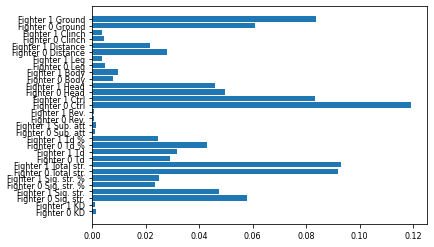

In [273]:
from sklearn.ensemble import RandomForestClassifier

# Train
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)

# Validate
accuracy_train = clf.score(X_train, y_train)
accuracy_valid = clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

# Visualize importances
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, clf.feature_importances_)

In [274]:
# Preview test performance
X_test[0:10]

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,...,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground
2686,0,0,68,29,51.0,49.0,132,37,4,3,...,6,5,3,14,46,27,7,2,15,0
2599,0,0,71,78,40.0,34.0,83,80,0,0,...,14,8,14,19,61,60,10,18,0,0
5059,0,0,92,74,36.0,30.0,103,102,3,0,...,11,16,15,8,78,67,14,7,0,0
3775,0,0,100,29,66.0,65.0,156,32,1,2,...,56,10,0,5,26,12,66,16,8,1
831,0,0,39,40,50.0,34.0,62,98,1,1,...,11,17,10,3,18,19,21,21,0,0
324,0,0,68,88,36.0,48.0,85,123,0,1,...,4,19,3,18,65,81,3,3,0,4
5201,0,0,19,11,44.0,34.0,68,90,7,1,...,3,0,2,5,11,1,4,1,4,9
962,0,0,48,65,35.0,59.0,50,75,0,0,...,7,6,11,11,42,32,6,18,0,15
407,0,0,44,20,63.0,34.0,241,27,3,0,...,6,5,3,2,19,16,2,4,23,0
5754,0,0,46,26,31.0,37.0,46,26,0,0,...,0,2,29,10,44,26,2,0,0,0


In [275]:
y_test[0:10]

,Winner
2686,0
2599,0
5059,0
3775,0
831,1
324,1
5201,0
962,1
407,0
5754,0


In [276]:
clf.predict(X_test[0:10])

array([0, 1, 0, 0, 1, 1, 0, 1, 0, 0])

### MLP

In [277]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
accuracy_train = clf.score(X_train, y_train)
accuracy_valid = clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/home/tylerlum/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


accuracy_train = 0.7657807308970099
accuracy_valid = 0.7617845117845118


### SVM

In [281]:
# SVM
from sklearn.svm import SVC

clf = SVC(random_state=1).fit(X_train, y_train)
accuracy_train = clf.score(X_train, y_train)
accuracy_valid = clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/home/tylerlum/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


accuracy_train = 0.8567275747508306
accuracy_valid = 0.8333333333333334


### Deep model

In [285]:
import tensorflow as tf

In [286]:
# FFN
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=X_train.shape[1:]))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 32)                992       
_________________________________________________________________
dense_88 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 33        
Total params: 2,081
Trainable params: 2,081
Non-trainable params: 0
_________________________________________________________________


In [287]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))
model.evaluate(X_train, y_train)
model.evaluate(X_valid, y_valid)

Train on 2408 samples, validate on 1188 samples
Epoch 1/100
2408/2408 [==============================] - 0s 144us/sample - loss: 1.9519 - acc: 0.7467 - val_loss: 0.9460 - val_acc: 0.7963
Epoch 2/100
2408/2408 [==============================] - 0s 38us/sample - loss: 0.7938 - acc: 0.8098 - val_loss: 0.7034 - val_acc: 0.8098
Epoch 3/100
2408/2408 [==============================] - 0s 37us/sample - loss: 0.6477 - acc: 0.8152 - val_loss: 0.8020 - val_acc: 0.7887
Epoch 4/100
2408/2408 [==============================] - 0s 37us/sample - loss: 0.5896 - acc: 0.8173 - val_loss: 0.5833 - val_acc: 0.8114
Epoch 5/100
2408/2408 [==============================] - 0s 40us/sample - loss: 0.4510 - acc: 0.8326 - val_loss: 0.5560 - val_acc: 0.8232
Epoch 6/100
2408/2408 [==============================] - 0s 39us/sample - loss: 0.4342 - acc: 0.8335 - val_loss: 0.5676 - val_acc: 0.8047
Epoch 7/100
2408/2408 [==============================] - 0s 39us/sample - loss: 0.4440 - acc: 0.8368 - val_loss: 0.5068 - v

2408/2408 [==============================] - 0s 39us/sample - loss: 0.2438 - acc: 0.8953 - val_loss: 0.4828 - val_acc: 0.8182
Epoch 60/100
2408/2408 [==============================] - 0s 41us/sample - loss: 0.2519 - acc: 0.8941 - val_loss: 0.4352 - val_acc: 0.8426
Epoch 61/100
2408/2408 [==============================] - 0s 49us/sample - loss: 0.2568 - acc: 0.8929 - val_loss: 0.4389 - val_acc: 0.8359
Epoch 62/100
2408/2408 [==============================] - 0s 38us/sample - loss: 0.2388 - acc: 0.8974 - val_loss: 0.4485 - val_acc: 0.8325
Epoch 63/100
2408/2408 [==============================] - 0s 35us/sample - loss: 0.2698 - acc: 0.8829 - val_loss: 0.4410 - val_acc: 0.8333
Epoch 64/100
2408/2408 [==============================] - 0s 37us/sample - loss: 0.2432 - acc: 0.8962 - val_loss: 0.4526 - val_acc: 0.8375
Epoch 65/100
2408/2408 [==============================] - 0s 39us/sample - loss: 0.2410 - acc: 0.8987 - val_loss: 0.5491 - val_acc: 0.7929
Epoch 66/100
2408/2408 [================

[0.5714649973493634, 0.81986535]

### Comparison Model

In [288]:
from tensorflow.keras.layers import Input, Lambda, Subtract, Activation
from tensorflow.keras.models import Model
def create_comparison_model(input_shape):
    num_features_per_fighter = input_shape[0] // 2

    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=num_features_per_fighter))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='relu'))
    
    # Run cnn model on each frame
    input_tensor = Input(shape=input_shape)
    fighter0_state = Lambda(lambda x: x[:, :num_features_per_fighter], name='fighter0_state')(input_tensor)
    fighter1_state = Lambda(lambda x: x[:, num_features_per_fighter:], name='fighter1_state')(input_tensor)

    fighter0_score = model(fighter0_state)
    fighter1_score = model(fighter1_state)
    fighter0_score = Lambda(lambda x: x, name='fighter0_score')(fighter0_score)
    fighter1_score = Lambda(lambda x: x, name='fighter1_score')(fighter1_score)
    
    difference_score = Subtract(name='subtracter')([fighter1_score, fighter0_score])
    prediction = Activation('sigmoid')(difference_score)
    return Model(inputs=input_tensor, outputs=prediction)

In [302]:
model = create_comparison_model(X.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
fighter1_state (Lambda)         (None, 15)           0           input_61[0][0]                   
__________________________________________________________________________________________________
fighter0_state (Lambda)         (None, 15)           0           input_61[0][0]                   
__________________________________________________________________________________________________
sequential_32 (Sequential)      (None, 1)            9473        fighter0_state[0][0]             
                                                                 fighter1_state[0][0]      

In [303]:
X_train.head()

,Fighter 0 KD,Fighter 0 Sig. str.,Fighter 0 Sig. str. %,Fighter 0 Total str.,Fighter 0 Td,Fighter 0 Td %,Fighter 0 Sub. att,Fighter 0 Rev.,Fighter 0 Ctrl,Fighter 0 Head,...,Fighter 1 Td %,Fighter 1 Sub. att,Fighter 1 Rev.,Fighter 1 Ctrl,Fighter 1 Head,Fighter 1 Body,Fighter 1 Leg,Fighter 1 Distance,Fighter 1 Clinch,Fighter 1 Ground
1730,0,33,33.0,76,1,100.0,0,0,17.0,22,...,80.0,0,0,169.0,33,19,14,53,8,5
4671,0,28,31.0,83,1,100.0,1,0,27.0,17,...,60.0,1,1,404.0,2,6,6,9,3,2
2465,0,104,67.0,193,7,63.0,0,0,522.0,73,...,0.0,2,0,63.0,23,4,0,20,5,2
2417,0,39,34.0,67,4,40.0,0,0,329.0,20,...,0.0,0,0,37.0,82,9,3,94,0,0
5204,1,26,39.0,79,2,100.0,3,2,648.0,23,...,50.0,0,1,155.0,11,2,3,14,1,1


In [304]:
fighter0_columns = [col for col in X_train.columns if "Fighter 0" in col]
fighter1_columns = [col for col in X_train.columns if "Fighter 1" in col]
print(f"fighter0_columns = {fighter0_columns}")
print(f"fighter1_columns = {fighter1_columns}")
new_columns = fighter0_columns + fighter1_columns

fighter0_columns = ['Fighter 0 KD', 'Fighter 0 Sig. str.', 'Fighter 0 Sig. str. %', 'Fighter 0 Total str.', 'Fighter 0 Td', 'Fighter 0 Td %', 'Fighter 0 Sub. att', 'Fighter 0 Rev.', 'Fighter 0 Ctrl', 'Fighter 0 Head', 'Fighter 0 Body', 'Fighter 0 Leg', 'Fighter 0 Distance', 'Fighter 0 Clinch', 'Fighter 0 Ground']
fighter1_columns = ['Fighter 1 KD', 'Fighter 1 Sig. str.', 'Fighter 1 Sig. str. %', 'Fighter 1 Total str.', 'Fighter 1 Td', 'Fighter 1 Td %', 'Fighter 1 Sub. att', 'Fighter 1 Rev.', 'Fighter 1 Ctrl', 'Fighter 1 Head', 'Fighter 1 Body', 'Fighter 1 Leg', 'Fighter 1 Distance', 'Fighter 1 Clinch', 'Fighter 1 Ground']


In [305]:
X_train = X_train[new_columns]
X_valid = X_valid[new_columns]
X_test = X_test[new_columns]

In [306]:
X_train.head()

,Fighter 0 KD,Fighter 0 Sig. str.,Fighter 0 Sig. str. %,Fighter 0 Total str.,Fighter 0 Td,Fighter 0 Td %,Fighter 0 Sub. att,Fighter 0 Rev.,Fighter 0 Ctrl,Fighter 0 Head,...,Fighter 1 Td %,Fighter 1 Sub. att,Fighter 1 Rev.,Fighter 1 Ctrl,Fighter 1 Head,Fighter 1 Body,Fighter 1 Leg,Fighter 1 Distance,Fighter 1 Clinch,Fighter 1 Ground
1730,0,33,33.0,76,1,100.0,0,0,17.0,22,...,80.0,0,0,169.0,33,19,14,53,8,5
4671,0,28,31.0,83,1,100.0,1,0,27.0,17,...,60.0,1,1,404.0,2,6,6,9,3,2
2465,0,104,67.0,193,7,63.0,0,0,522.0,73,...,0.0,2,0,63.0,23,4,0,20,5,2
2417,0,39,34.0,67,4,40.0,0,0,329.0,20,...,0.0,0,0,37.0,82,9,3,94,0,0
5204,1,26,39.0,79,2,100.0,3,2,648.0,23,...,50.0,0,1,155.0,11,2,3,14,1,1


In [307]:
H = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))
model.evaluate(X_train, y_train)
model.evaluate(X_valid, y_valid)

Train on 2408 samples, validate on 1188 samples
Epoch 1/100
2408/2408 [==============================] - 0s 176us/sample - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/100
2408/2408 [==============================] - 0s 43us/sample - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/100
2408/2408 [==============================] - 0s 46us/sample - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/100
2408/2408 [==============================] - 0s 43us/sample - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/100
2408/2408 [==============================] - 0s 42us/sample - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/100
2408/2408 [==============================] - 0s 42us/sample - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 7/100
2408/2408 [==============================] - 0s 43us/sample - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - v

2408/2408 [==============================] - 0s 43us/sample - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 60/100
2408/2408 [==============================] - 0s 42us/sample - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 61/100
2408/2408 [==============================] - 0s 42us/sample - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 62/100
2408/2408 [==============================] - 0s 43us/sample - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 63/100
2408/2408 [==============================] - 0s 41us/sample - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 64/100
2408/2408 [==============================] - 0s 41us/sample - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 65/100
2408/2408 [==============================] - 0s 43us/sample - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 66/100
2408/2408 [================

[0.6931471824645996, 0.5]

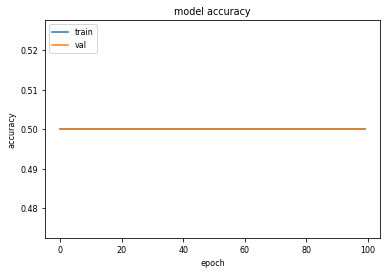

In [308]:
from matplotlib import pyplot as plt
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [309]:
model.predict(X_test[4:10])

array([[0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5]], dtype=float32)

In [310]:
y_test[4:10]

,Winner
831,1
324,1
5201,0
962,1
407,0
5754,0


In [311]:
subtracter = model.get_layer('subtracter').output
subtracter = Model(model.input, subtracter)
subtracter.predict(X_test[4:10])

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [312]:
fighter0_score = model.get_layer('fighter0_score').output
fighter0_score = Model(model.input, fighter0_score)
fighter0_score.predict(X_test[4:10])

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [313]:
fighter1_score = model.get_layer('fighter1_score').output
fighter1_score = Model(model.input, fighter1_score)
fighter1_score.predict(X_test[4:10])

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)